In [1]:
# 时间序列分析

In [2]:
## PM2.5

In [3]:
### pm25_convert

In [1]:
# 将原始数据格式中的year, month, day, hour进行合并，并保存新的文件pollution.csv
from pandas import read_csv
from datetime import datetime

import os
import warnings
warnings.filterwarnings('ignore')
path = os.path.expanduser('~/data/')

In [5]:
# 数据加载
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv(path + '/BI/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

In [7]:
# 列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 缺失值填充
dataset['pollution'].fillna(0, inplace=True)
# 去掉第一天数据（前24小时）
dataset = dataset[24:]
# 数据浏览
print(dataset.head(5))
# 数据保存
dataset.to_csv(path + '/BI/out_pollution.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-03 00:00:00       90.0   -7  -6.0  1027.0      SE    58.56     4     0
2010-01-03 01:00:00       63.0   -8  -6.0  1026.0      SE    61.69     5     0
2010-01-03 02:00:00       65.0   -8  -7.0  1026.0      SE    65.71     6     0
2010-01-03 03:00:00       55.0   -8  -7.0  1025.0      SE    68.84     7     0
2010-01-03 04:00:00       65.0   -8  -7.0  1024.0      SE    72.86     8     0


In [8]:
### 使用LSTM对PM2.5进行预测，根据8个特征维度预测PM指数 pollution

In [9]:
import pandas as pd
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from itertools import chain

Using TensorFlow backend.
/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

In [10]:
"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""

'\n将时间序列数据转换为适用于监督学习的数据\n给定输入、输出序列的长度\ndata: 观察序列\nn_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1\nn_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1\ndropnan: 是否删除NaN行\n返回值：适用于监督学习的 DataFrame\n'

In [11]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
# 数据加载
dataset = read_csv(path + '/BI/pollution.csv', header=0, index_col=0)
values = dataset.values
print(values)
print(values.shape)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
(43800, 8)


In [14]:
# 设置需要可视化的列表
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# 数据探索EDA
#plt.figure()

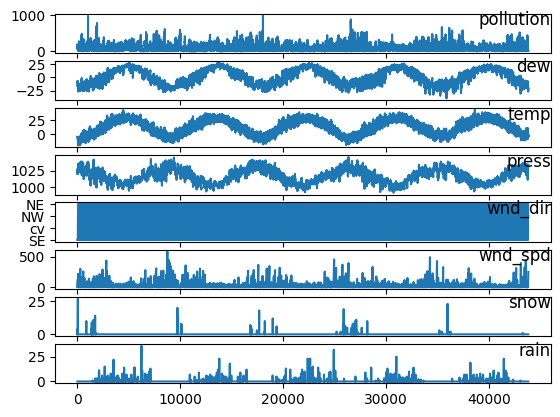

In [15]:
for group in range(8):
	plt.subplot(8, 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [16]:
# 将分类特征wnd_dir 进行标签编码
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 设置数据类型均为flast32
values = values.astype('float32')
#pd.DataFrame(values).to_csv('values.csv')
print(values)

[[129.   -16.    -4.   ...   1.79   0.     0.  ]
 [148.   -15.    -4.   ...   2.68   0.     0.  ]
 [159.   -11.    -5.   ...   3.57   0.     0.  ]
 ...
 [ 10.   -22.    -3.   ... 242.7    0.     0.  ]
 [  8.   -22.    -4.   ... 246.72   0.     0.  ]
 [ 12.   -21.    -3.   ... 249.85   0.     0.  ]]


In [17]:
# 对所有数据进行0-1规范化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)


(43800, 8)


In [18]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.010060   0.264706   0.262295   0.781818   0.333333   0.405588   
43798   0.010060   0.264706   0.262295   0.781818   0.333333   0.413996   
43799   0.008048   0.264706   0.245902   0.781818   0.333333   0.420866   

       var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1       0.000000  

In [19]:
reframed.to_csv(path + '/BI/out_reframed-1.csv')
# 去掉不需要预测的列，即var2(t)	var3(t)	var4(t)	var5(t)	var6(t)	var7(t)	var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv(path + '/BI/out_reframed-2.csv')
#print(reframed.head())

In [20]:
# 训练集80%，测试集20%
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [21]:

# :-1表示从0到数组最后一位，-1表示数组最后一位
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)

(35039, 8)


In [22]:
# 转换成3D格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X)
#print(test_X)


In [23]:
# 设置网络模型
model = Sequential()
print('shape = ', train_X.shape)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1,8, train_X.shape = (35039, 1, 8)
print(test_X.shape[2])
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

shape =  (35039, 1, 8)
8


In [24]:
# 模型训练, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
result = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)



Train on 35039 samples, validate on 8760 samples
Epoch 1/10
 - 5s - loss: 0.0025 - val_loss: 0.0041
Epoch 2/10
 - 4s - loss: 8.2478e-04 - val_loss: 0.0016
Epoch 3/10
 - 4s - loss: 8.0428e-04 - val_loss: 0.0013
Epoch 4/10
 - 4s - loss: 8.0892e-04 - val_loss: 0.0013
Epoch 5/10
 - 3s - loss: 8.0861e-04 - val_loss: 0.0012
Epoch 6/10
 - 3s - loss: 8.0645e-04 - val_loss: 0.0012
Epoch 7/10
 - 3s - loss: 8.0408e-04 - val_loss: 0.0012
Epoch 8/10
 - 4s - loss: 8.0187e-04 - val_loss: 0.0012
Epoch 9/10
 - 4s - loss: 7.9990e-04 - val_loss: 0.0012
Epoch 10/10
 - 4s - loss: 7.9815e-04 - val_loss: 0.0012


In [25]:
# 模型预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)


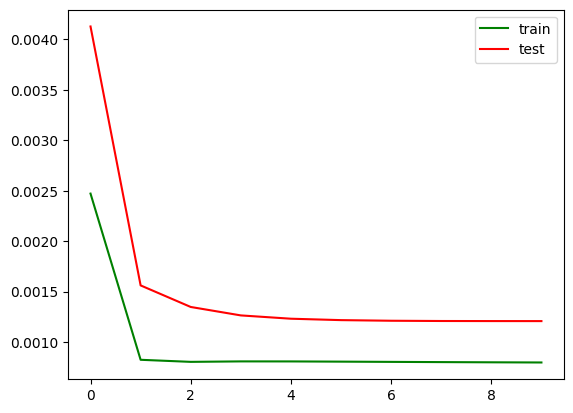

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
# 绘制训练损失和测试损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()
print(model.summary())


In [27]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_predict, test_predict):
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], label='real', c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], label='train predict', c='g')
    # 预测结果红色
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test predict', c='r')
    plt.legend()
    plt.show()

/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


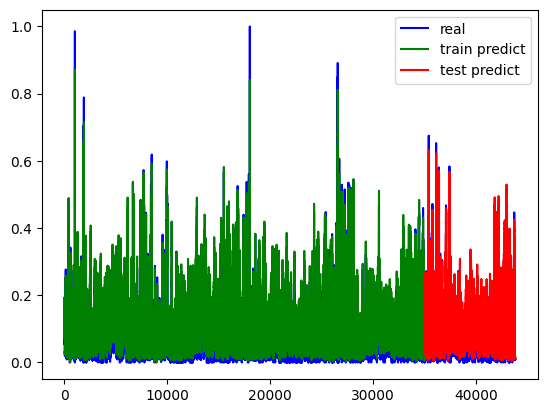

In [28]:
# 绘制预测结果与实际结果对比
plot_img(values, train_predict, test_predict)

In [29]:
## Stock

In [30]:
### 用ARMA进行时间序列预测

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot

In [32]:
# 创建数据
data = [3821, 4236, 3758, 6783, 4664, 2589, 2538, 3542, 4626, 5886, 6233, 4199, 3561, 2335, 5636, 3524, 
4327, 6064, 3912, 1356, 4305, 4379, 4592, 4233, 4281, 1613, 1233, 4514, 3431, 2159, 2322, 4239, 4733, 
2268, 5397, 5821, 6115, 6631, 6474, 4134, 2728, 5753, 7130, 7860, 6991, 7499, 5301, 2808, 6755, 6658, 
6944, 6372, 8380, 7366, 6352, 8333, 8281, 11548, 10823, 13642, 9973, 6723, 13416, 12205, 13942, 9590, 
11693, 9276, 6519, 6863, 8237, 10122, 8646, 9749, 5346, 4836, 9806, 7502, 9387, 11078, 9832, 6886, 4285, 
8351, 9725, 11844, 12387, 10666, 7072, 6429]
data=pd.Series(data)
data_index = sm.tsa.datetools.dates_from_range('1901','1990')
#print(data_index)

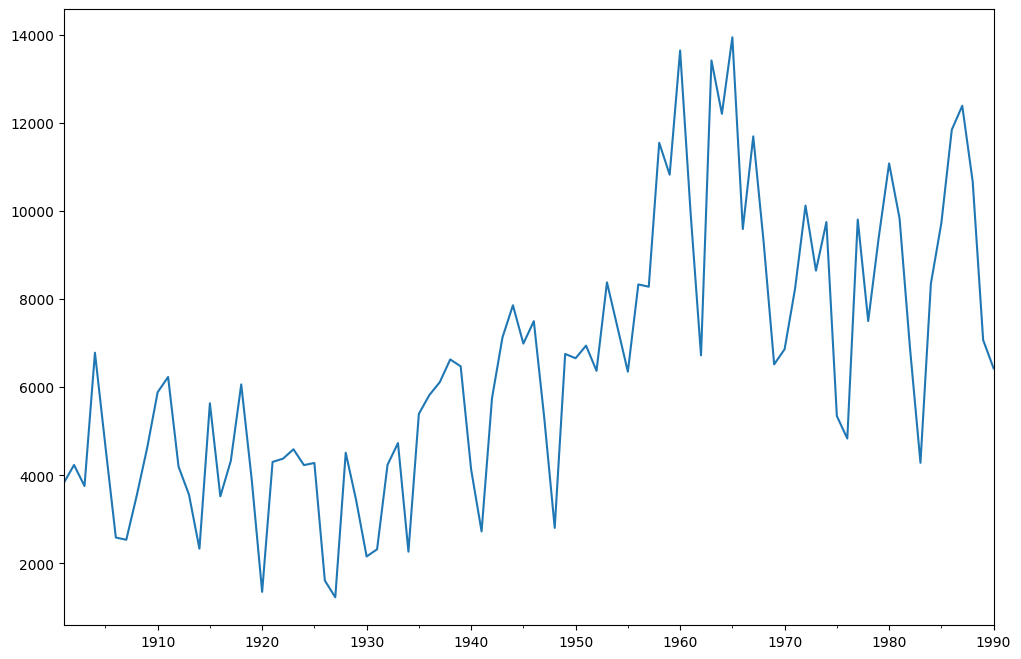

/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency inf

AIC: 1615.9965


/Users/du/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


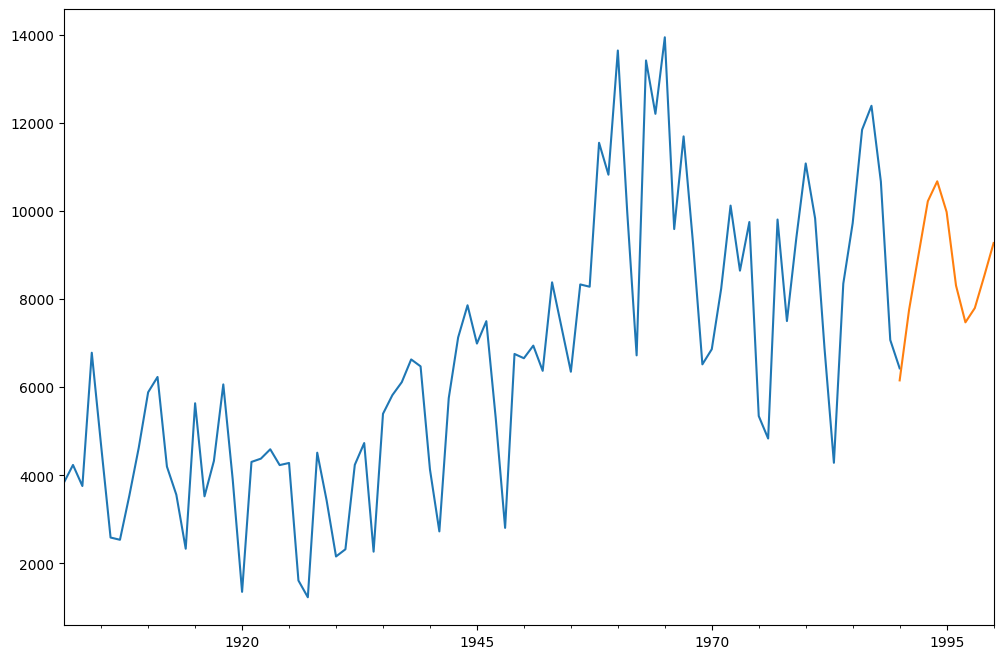

In [33]:
# 绘制数据图
data.index = pd.Index(data_index)
data.plot(figsize=(12,8))
plt.show()
# 创建ARMA模型# 创建ARMA模型
arma = ARMA(data,(7,0)).fit()
print('AIC: %0.4lf' %arma.aic)
# 模型预测
predict_y = arma.predict('1990', '2000')
# 预测结果绘制
fig, ax = plt.subplots(figsize=(12, 8))
ax = data.loc['1901':].plot(ax=ax)
predict_y.plot(ax=ax)
plt.show()


In [34]:
### 沪市指数走势预测，使用时间序列ARMA

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')

In [36]:
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] #用来正常显示中文标签

In [37]:
# 数据加载
df = pd.read_csv(path + '/BI/shanghai_index_1990_12_19_to_2020_03_12.csv')
df = df[['Timestamp', 'Price']]


In [38]:

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)

            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   99.98
1990-12-20 1990-12-20  104.39
1990-12-21 1990-12-21  109.13
1990-12-24 1990-12-24  114.55
1990-12-25 1990-12-25  120.25
                  Price
Timestamp              
1990-12-31   116.990000
1991-01-31   132.628182
1991-02-28   131.887778
1991-03-31   126.011429
1991-04-30   118.426818
...                 ...
2019-11-30  2923.774700
2019-12-31  2962.063709
2020-01-31  3078.654681
2020-02-29  2927.513035
2020-03-31  2990.415289

[352 rows x 1 columns]


In [39]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)


In [40]:
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

In [41]:
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  352
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -2249.762
Date:                Thu, 02 Sep 2021   AIC                           4511.524
Time:                        00:38:15   BIC                           4534.603
Sample:                    12-31-1990   HQIC                          4520.714
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5618      0.163      3.454      0.001       0.243       0.881
ma.L1         -0.2268      0.164     -1.381      0.167      -0.549       0.095
ma.L2         -0.0453      0.058     -0.783  

In [42]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

date_list= [Timestamp('2020-04-30 00:00:00', freq='M'), Timestamp('2020-05-31 00:00:00', freq='M'), Timestamp('2020-06-30 00:00:00', freq='M')]


In [43]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

In [44]:
# get_prediction得到的是区间，使用predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean

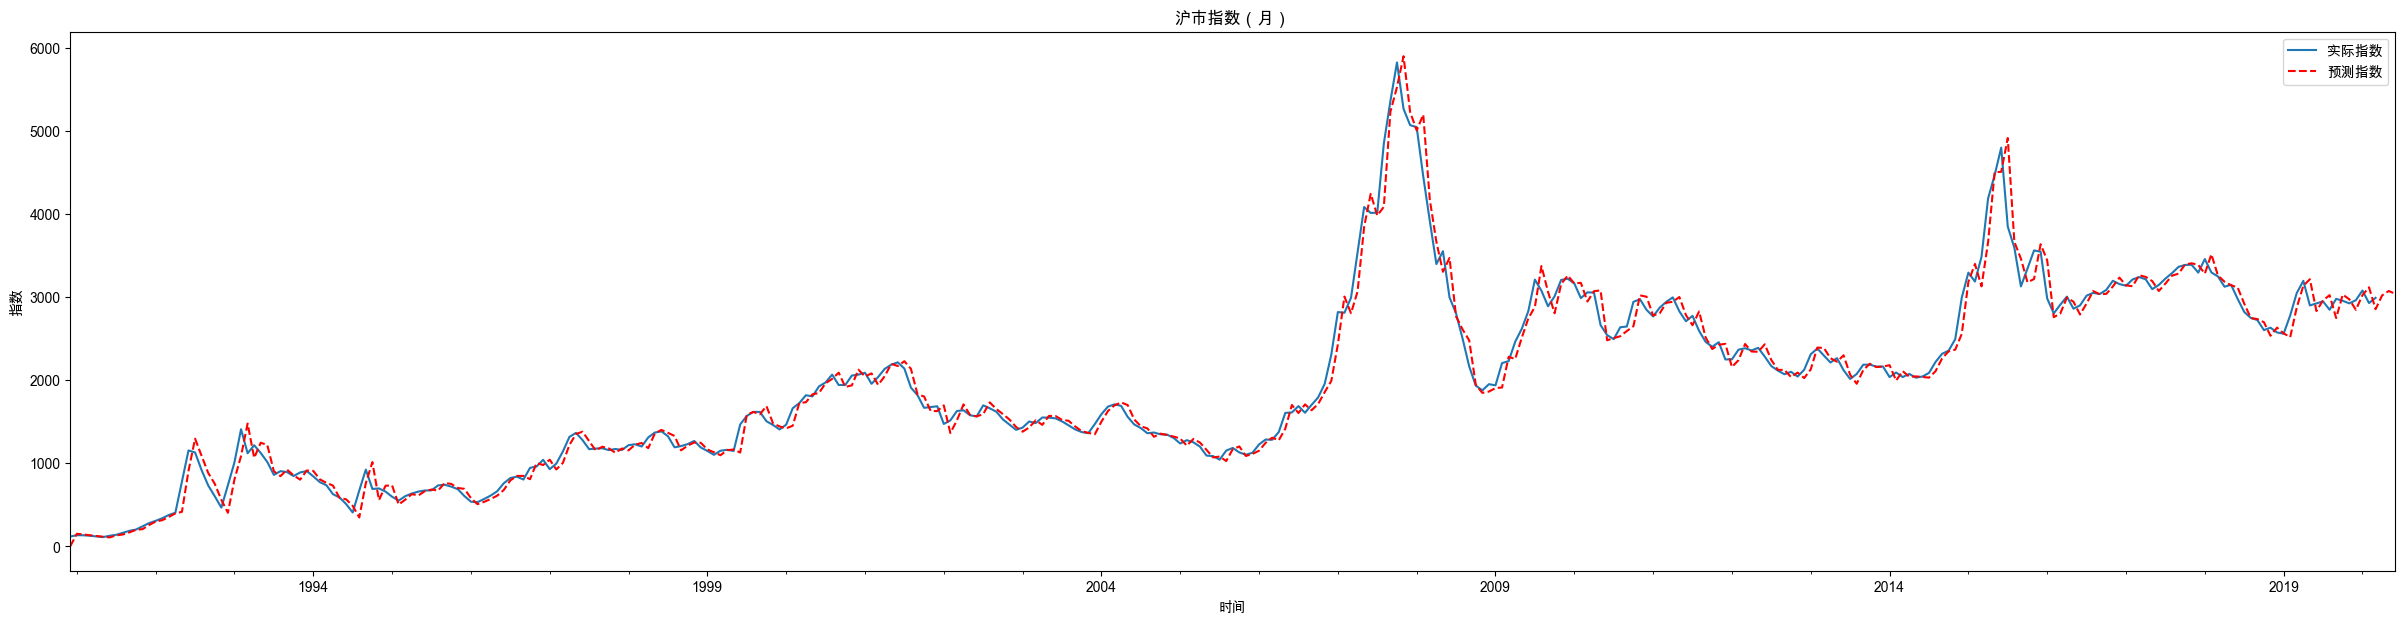

In [45]:
# 沪市指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()

In [46]:
### 沪市指数走势预测，使用时间序列ARMA

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [48]:
warnings.filterwarnings('ignore')

In [49]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   99.98
1990-12-20 1990-12-20  104.39
1990-12-21 1990-12-21  109.13
1990-12-24 1990-12-24  114.55
1990-12-25 1990-12-25  120.25
                  Price
Timestamp              
1990-12-31   116.990000
1991-01-31   132.628182
1991-02-28   131.887778
1991-03-31   126.011429
1991-04-30   118.426818
...                 ...
2019-11-30  2923.774700
2019-12-31  2962.063709
2020-01-31  3078.654681
2020-02-29  2927.513035
2020-03-31  2990.415289

[352 rows x 1 columns]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


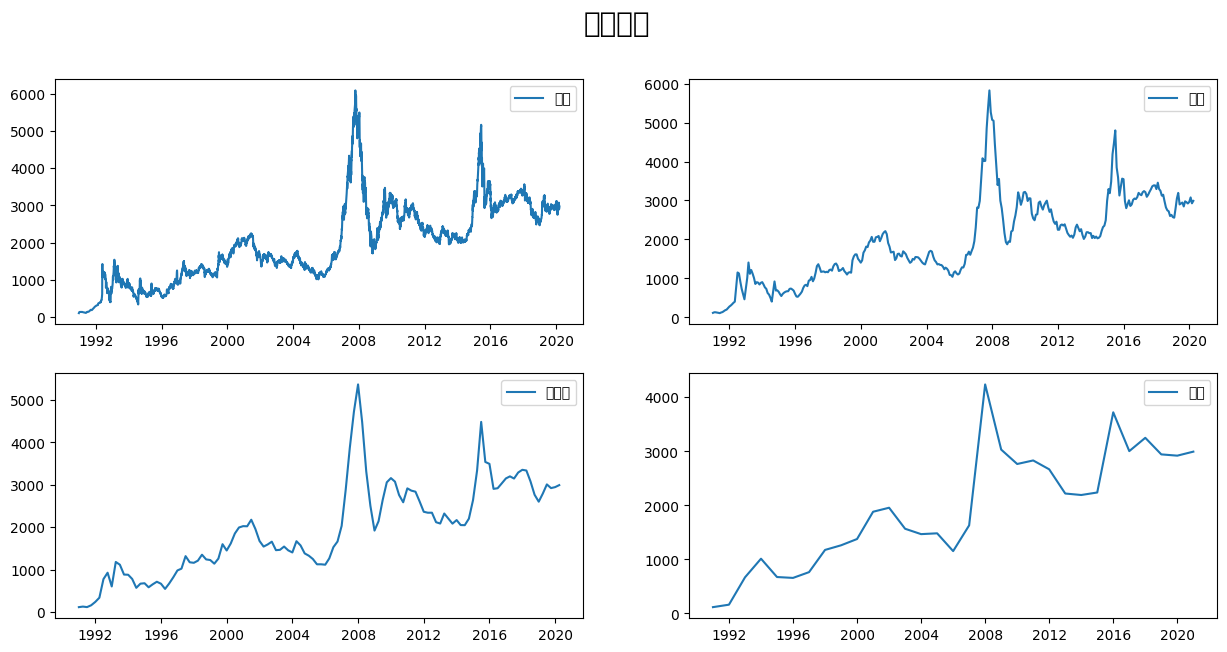

In [50]:
# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] #用来正常显示中文标签
plt.suptitle('沪市指数', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

In [51]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

In [52]:
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

参数错误: (0, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  352
Model:                     ARMA(2, 2)   Log Likelihood               -2290.943
Method:                       css-mle   S.D. of innovations            161.347
Date:                Thu, 02 Sep 2021   AIC                           4593.887
Time:                        00:39:17   BIC                           4617.069
Sample:                    12-31-1990   HQIC                          4603.112
                         - 03-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1885.9487    497.725      3.789      0.000     910.425    2861.472
ar.L1.Price     0.4820      0.129      3.726      0.000       0.228       0.735
ar.L2.Price     0.4832      

In [53]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

date_list= [Timestamp('2020-04-30 00:00:00', freq='M'), Timestamp('2020-05-31 00:00:00', freq='M'), Timestamp('2020-06-30 00:00:00', freq='M')]


In [54]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))

In [55]:
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

                  Price     forecast
1990-12-31   116.990000          NaN
1991-01-31   132.628182   138.796527
1991-02-28   131.887778   167.319025
1991-03-31   126.011429   161.399147
1991-04-30   118.426818   147.435744
...                 ...          ...
2020-02-29  2927.513035  3097.946486
2020-03-31  2990.415289  2847.866496
2020-04-30          NaN  2982.520253
2020-05-31          NaN  3000.968033
2020-06-30          NaN  2953.189326

[355 rows x 2 columns]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


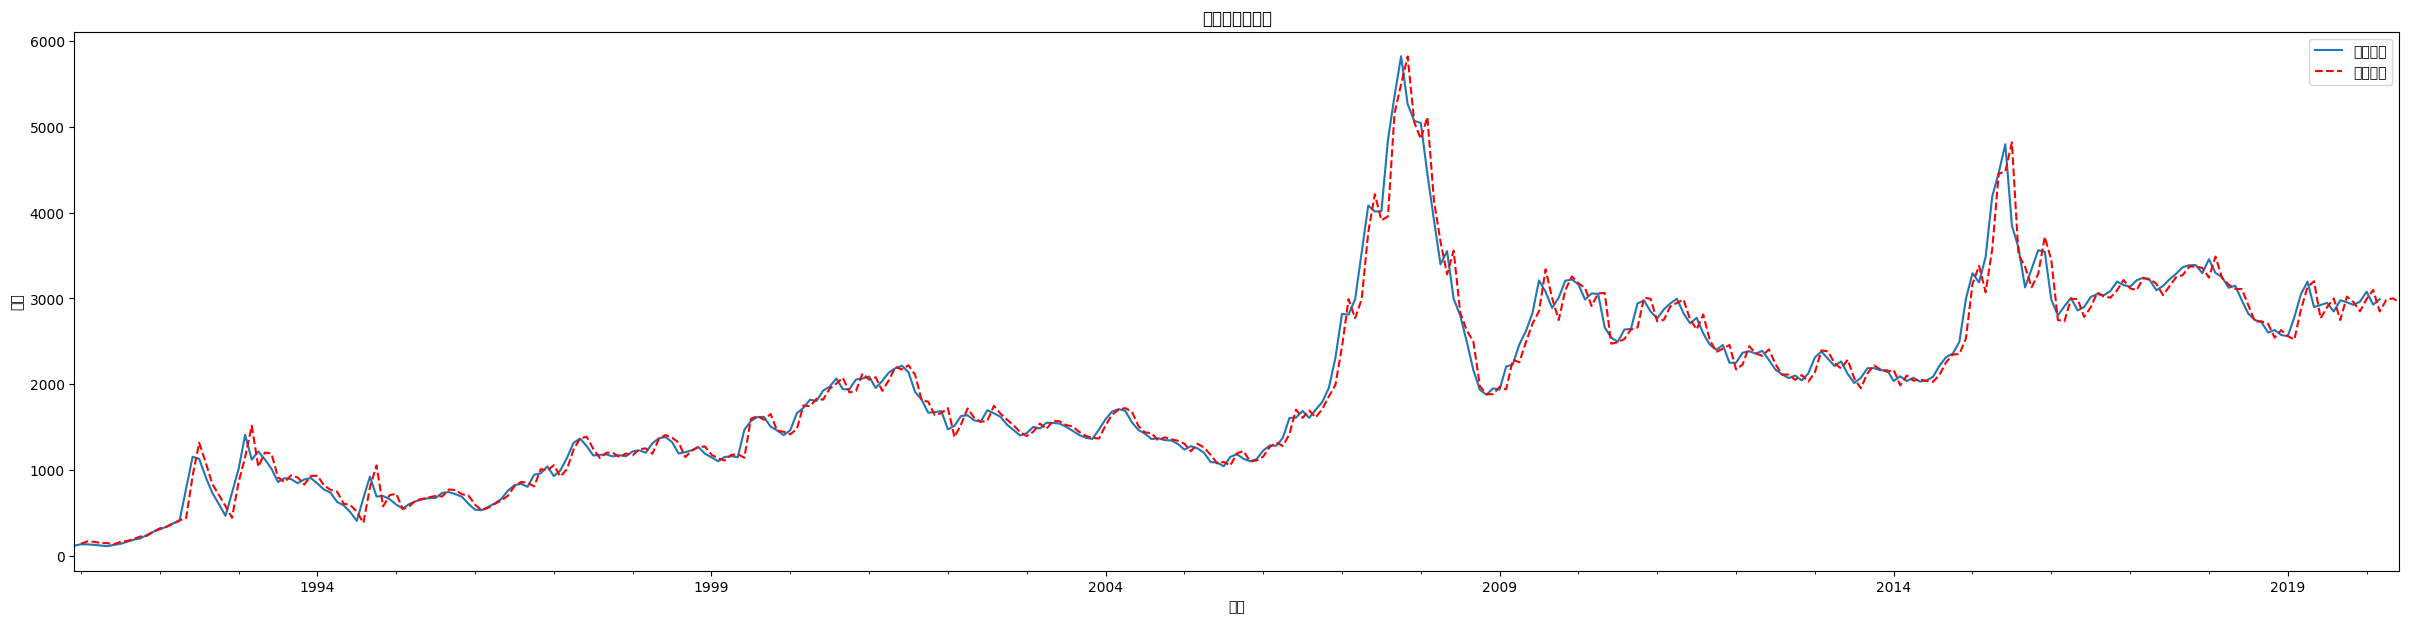

In [56]:
# 沪市指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()

In [57]:
### 使用LSTM预测沪市指数

In [58]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [59]:
# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    print(reframed_train_data_set)
    print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

In [61]:
"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [62]:
# 使用LSTM进行预测
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    
    # 第一层, 隐藏层神经元节点个数为128, 返回整个序列
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    # 第三层 因为是回归问题所以使用linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # LSTM训练 input_epochs次数, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, train_predict)

In [63]:
# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

In [65]:
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 500
batch_size = 100
data = pd.read_csv(path + '/BI/shanghai_index_1990_12_19_to_2020_03_12.csv')
data_set = data[['Price']].values.astype('float64')

In [66]:
# 转化为可以用于监督学习的数据
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

[[  99.98    104.39    109.13    114.55    120.25    125.27  ]
 [ 104.39    109.13    114.55    120.25    125.27    125.28  ]
 [ 109.13    114.55    120.25    125.27    125.28    126.45  ]
 ...
 [2992.8968 3011.6657 3071.6771 3034.5113 2943.2907 2996.7618]
 [3011.6657 3071.6771 3034.5113 2943.2907 2996.7618 2968.5174]
 [3071.6771 3034.5113 2943.2907 2996.7618 2968.5174 2923.4856]]
(7140, 6)


In [67]:
# 使用LSTM进行训练、预测
lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)

Epoch 1/500
 - 4s - loss: 4934819.8678
Epoch 2/500
 - 3s - loss: 4894044.1606
Epoch 3/500
 - 2s - loss: 4860928.8709
Epoch 4/500
 - 2s - loss: 4828682.8115
Epoch 5/500
 - 3s - loss: 4796735.0034
Epoch 6/500
 - 2s - loss: 4765724.2321
Epoch 7/500
 - 2s - loss: 4734840.5822
Epoch 8/500
 - 2s - loss: 4703290.3625
Epoch 9/500
 - 2s - loss: 4673055.9703
Epoch 10/500
 - 2s - loss: 4643348.7150
Epoch 11/500
 - 2s - loss: 4613899.6996
Epoch 12/500
 - 3s - loss: 4583387.6820
Epoch 13/500
 - 2s - loss: 4554479.1703
Epoch 14/500
 - 2s - loss: 4524838.2392
Epoch 15/500
 - 2s - loss: 4497012.3382
Epoch 16/500
 - 2s - loss: 4467364.5068
Epoch 17/500
 - 2s - loss: 4440897.6383
Epoch 18/500
 - 2s - loss: 4411723.4319
Epoch 19/500
 - 3s - loss: 4383447.9452
Epoch 20/500
 - 3s - loss: 4355058.0123
Epoch 21/500
 - 2s - loss: 4327300.1564
Epoch 22/500
 - 2s - loss: 4300835.2765
Epoch 23/500
 - 2s - loss: 4272911.2117
Epoch 24/500
 - 2s - loss: 4244658.1060
Epoch 25/500
 - 2s - loss: 4218390.9461
Epoch 26/

In [ ]:
### 使用tsa对沪市指数进行分析：trend, seasonal, residual

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# 数据加载
data = pd.read_csv(path + '/BI/shanghai_index_1990_12_19_to_2020_03_12.csv', usecols=['Timestamp', 'Price'])
data.Timestamp = pd.to_datetime(data.Timestamp)
data = data.set_index('Timestamp')
data['Price'] = data['Price'].apply(pd.to_numeric, errors='ignore')

In [ ]:
# 进行线性插补缺漏值
data.Price.interpolate(inplace=True)
#  返回三个部分 trend（趋势），seasonal（季节性）和residual (残留)
result = sm.tsa.seasonal_decompose(data.Price, freq=288)
result.plot()
plt.show()